In [1]:
import gymnasium as gym
import socnavgym
import torch
import torch.nn as nn
import torch.nn.functional as F
from socnavgym.wrappers import DiscreteActions
from socnavgym.wrappers import ExpertObservations
from stable_baselines3 import DQN
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from math import sqrt
import argparse
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.results_plotter import ts2xy, plot_results
from stable_baselines3.common.utils import safe_mean
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
import imageio
import socnavgym
import gymnasium as gym
from socnavgym.wrappers import DiscreteActions
from rl.QLearning import *
from rl.MSR_dec import *
from rl.SR import *
from rl.SF import *
from rl.DQN import *
from rl.SR import *
from tqdm.auto import trange
import imageio
from utils.StateDiscretizer import *
from utils.TileCoder import *

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
env = gym.make("SocNavGym-v1", config="./configs/2_humans.yaml") 
env = DiscreteActions(env)

EPISODES = 1000

/home/adonis/Documents/Thesis/socnavgym/SocNavGym/socnavgym/envs/utils/sngnnv2/socnav_V2_API.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.GNNmodel.load_state_di

In [3]:
#def train_worker(EPISODES, i):
env = gym.make("SocNavGym-v1", config="./configs/4_humans.yaml") 
env = DiscreteActions(env)
discretizer = StateDiscretizer(xy_bins=30, env=env)
agent = MSR(
        action_size=7,
        learning_rate_topo=0.2,
        learning_rate_social=0.2,
        r_learning_rate_topo=0.2,
        r_learning_rate_social=0.2,
        gamma=0.5, epsilon=0.05, discretizer=discretizer
)       
rewards_msr = []
length_msr = []
for episode in trange(EPISODES):
    obs = env.reset()
    episodes_length, episodes_rewards = agent.act(env, obs, upd_social=True)
    length_msr.append(episodes_length)
    rewards_msr.append(episodes_rewards)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
all_length_msr = length_msr
all_reward_msr = rewards_msr
length_mean_msr = all_length_msr
reward_mean_msr = all_reward_msr

In [5]:
def rolling_avg(x, w=40):
        return np.convolve(x, np.ones(w) / w, mode='valid')

In [6]:
length_rolling_msr = rolling_avg(length_mean_msr)
rewards_rolling_msr = rolling_avg(reward_mean_msr)

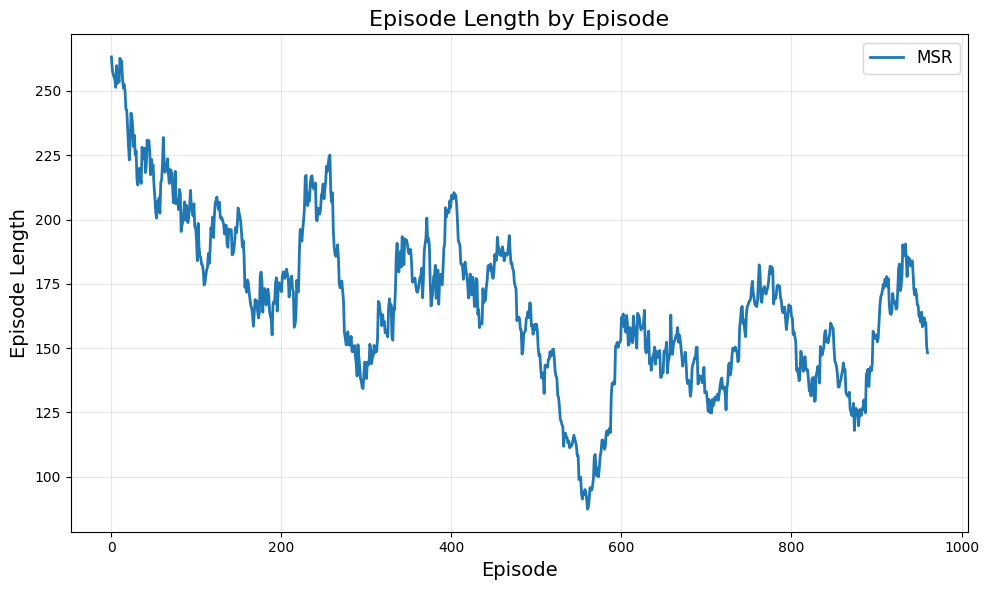

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(length_rolling_msr,  linewidth=2, label="MSR")

ax.set_title("Episode Length by Episode", fontsize=16)
ax.set_xlabel("Episode", fontsize=14)
ax.set_ylabel("Episode Length", fontsize=14)

ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

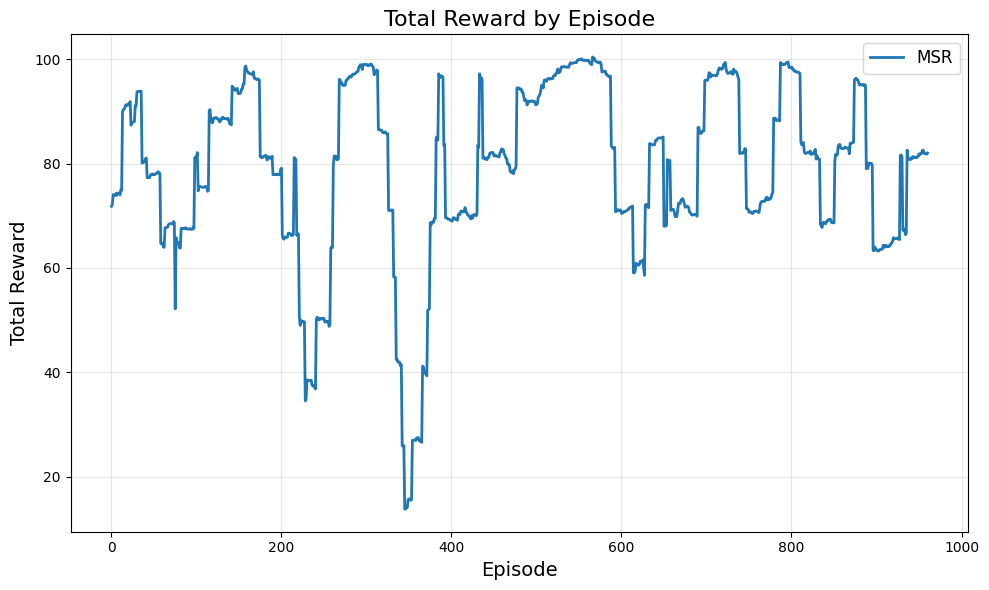

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(rewards_rolling_msr,  linewidth=2, label="MSR")

ax.set_title("Total Reward by Episode", fontsize=16)
ax.set_xlabel("Episode", fontsize=14)
ax.set_ylabel("Total Reward", fontsize=14)

ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import cv2

# Gymnasium reset returns (obs, info)
obs, info = env.reset()

# IMPORTANT: use the base env for rendering utilities
base_env = env.unwrapped

while True:
    # Uses your existing discretizer-grid renderer via env.render_debug(...)
    base_env.render_debug(obs, discretizer, show=True, delay_ms=30)

    action = agent.sample_action(agent.get_state_key(obs))
    obs, reward, terminated, truncated, info = env.step(action)

    if cv2.waitKey(1) == 27:  # ESC
        break

    if terminated or truncated:
        obs, info = env.reset()

env.close()
cv2.destroyAllWindows()